# Using convolutional neural nets to detect facial keypoints 

The goal of this task is to predict the location of key points on the face image. This can be used as a building block in several applications, for example:

* Track the position of faces in images and videos
* Analyze facial expressions
* Deformed facial signs for medical diagnosis
* Biometrics / Face Recognition

![face](https://imgur.com/tx9H0t7.png)

## Dataset description

The training dataset for face key detection challenge consisted of 7,049 96 × 96 grayscale images. For each image, we should find the correct position (x and y coordinates) for the 15 key points, such as `left_eye_center`, `right_eye_outer_corner`, `mouth_center_bottom_lip`, and so on.

This task can be obtained by [kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). Interestingly, we have only about 2,000 tags for some of the key points, and over 7,000 for other key points for training. For example, `left_eye_center_x` has 7,034 data, but only 2,266 `left_eye_inner_corner_x`.

## Preprocessing

In [13]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

FTRAIN = 'D:/Program/dataset/Facial Keypoints Detection/training.csv'
FTEST = 'D:/Program/dataset/Facial Keypoints Detection/test.csv'
FLOOKUP = 'D:/Program/dataset/Facial Keypoints Detection/IdLookupTable.csv'

df = pd.read_csv(FTRAIN)

print(df.shape)
df.head(2)

(7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


In [25]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(fname)
    
    # The Image field has pixel values and converts to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    # Extracts data related to a specific field
    if cols:
        df = df[list(cols) + ['Image']]
    
    # The number of data sets
    print(df.count())
    # Delete the missing data
    df = df.dropna() 
    
    # normalize
    X = np.vstack(df['Image'].values) / 255. 
    X = X.astype(np.float32) 
    
    # Only FTRAIN has a target label (label)
    if not test: 
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        
        # Shuffle the data
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y

def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    
    # Convolutional input shape converted to Conv2D
    X = X.reshape(-1, 96, 96, 1) 
    
    return X, y

First, let's start by listing the number of values available for each column. So, while all the rows in the training data have pixel values for the image, we have only 2,267 values for `mouth_right_corner_x`, and so on.

## The first model: only a single hidden layer 

First, let's implement a feedforward neural network that has only a single hidden middle layer. This is a simple model, with relatively few parameters involved, so it does not take too much time to train the model. We can use it as the base line for optimization later.

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(9216,)))

# Because there are 15 key coordinates (x, y), a total of 30 coordinates to predict
model.add(Dense(30)) 

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
# Use "MSE" as the loss function
model.compile(loss='mean_squared_error', optimizer=sgd) 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


In [27]:
X, y = load()

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

batch_size = 32
epochs = 100

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [28]:
history = model.fit(X, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2 
                   )

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0826 - val_loss: 0.0119
Epoch 2/100
1712/1712 [==============================] - 0s 261us/step - loss: 0.0101 - val_loss: 0.0090
Epoch 3/100
1712/1712 [==============================] - 0s 262us/step - loss: 0.0090 - val_loss: 0.0086
Epoch 4/100
1712/1712 [==============================] - 0s 243us/step - loss: 0.0082 - val_loss: 0.0086
Epoch 5/100
1712/1712 [==============================] - 0s 245us/step - loss: 0.0077 - val_loss: 0.0075
Epoch 6/100
1712/1712 [==============================] - 0s 244us/step - loss: 0.0075 - val_loss: 0.0073
Epoch 7/100
1712/1712 [==============================] - 0s 233us/step - loss: 0.0071 - val_loss: 0.0069
Epoch 8/100
1712/1712 [==============================] - 0s 229us/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/100
1712/1712 [==============================] - 0s 226us/step - loss: 0.0067 - val_loss: 0.0068
Epoch 10/1

Epoch 78/100
1712/1712 [==============================] - 0s 228us/step - loss: 0.0033 - val_loss: 0.0039
Epoch 79/100
1712/1712 [==============================] - 0s 261us/step - loss: 0.0033 - val_loss: 0.0040
Epoch 80/100
1712/1712 [==============================] - 0s 247us/step - loss: 0.0032 - val_loss: 0.0042
Epoch 81/100
1712/1712 [==============================] - 0s 224us/step - loss: 0.0032 - val_loss: 0.0040
Epoch 82/100
1712/1712 [==============================] - 0s 216us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 83/100
1712/1712 [==============================] - 0s 245us/step - loss: 0.0033 - val_loss: 0.0038
Epoch 84/100
1712/1712 [==============================] - 0s 239us/step - loss: 0.0032 - val_loss: 0.0040
Epoch 85/100
1712/1712 [==============================] - 0s 250us/step - loss: 0.0032 - val_loss: 0.0038
Epoch 86/100
1712/1712 [==============================] - 0s 254us/step - loss: 0.0031 - val_loss: 0.0038
Epoch 87/100
1712/1712 [======================

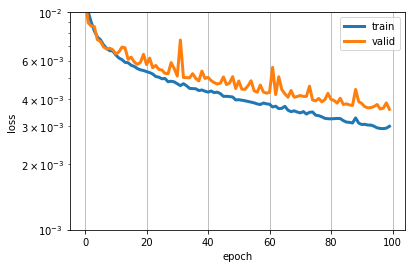

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)

# Because of the large range of losses, we use 'log' to convert
plt.yscale('log') 
plt.show()

## Evaluation

In [30]:
X_test, _ = load(test=True)
y_pred = model.predict(X_test) 

ImageId    1783
Image      1783
dtype: int64


In [32]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96) 
    axis.imshow(img, cmap='gray') 
    
    # The 15 face keys predicted by the model are printed on the image
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

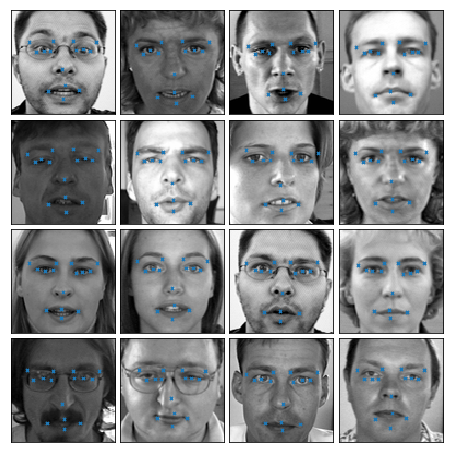

In [35]:
# Print a 6x6 image grid
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Select the first 16 test images for visualization
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)

plt.show()

## The second model: convolutional networks

In [36]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split

In [37]:
# Expand keras ImageDataGenerator to generate more image data
class FlippedImageDataGenerator(ImageDataGenerator):
    # Since the key point of the face is left to right, we will use the 'flip' method to generate the image
    flip_indices = [(0, 2), (1, 3), (4, 8), (5, 9),
                    (6, 10), (7, 11), (12, 16), (13, 17),
                    (14, 18), (15, 19), (22, 24), (23, 25)]
    
    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        
        # Randomly select some images for horizontal mirroring (flip)
        indices = np.random.choice(batch_size, batch_size / 2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]
        
        # For images that have been horizontally mirrored, the key coordinate points are also swapped
        if y_batch is not None:
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

In [38]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     padding='same', activation='relu', 
                     kernel_initializer='he_normal', input_shape=(96,96,1)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Because there are 15 key coordinates (x, y), a total of 30 coordinates to predict
    model.add(Dense(30)) 
    
    return model

model2 = cnn_model()

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
__________

In [39]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)

In [40]:
X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

epochs = 100

# Generate an image generator instance
flipgen = FlippedImageDataGenerator()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [42]:
history = model2.fit_generator(flipgen.flow(X_train, y_train),
                               steps_per_epoch=len(X_train)//batch_size,
                               epochs=epochs, 
                               validation_data=(X_val, y_val)
                              )

Epoch 1/100
53/53 [==============================] - 5s 95ms/step - loss: 0.0265 - val_loss: 0.0156
Epoch 2/100
53/53 [==============================] - 4s 85ms/step - loss: 0.0201 - val_loss: 0.0119
Epoch 3/100
53/53 [==============================] - 5s 87ms/step - loss: 0.0172 - val_loss: 0.0099
Epoch 4/100
53/53 [==============================] - 5s 86ms/step - loss: 0.0149 - val_loss: 0.0085
Epoch 5/100
53/53 [==============================] - 5s 87ms/step - loss: 0.0131 - val_loss: 0.0079
Epoch 6/100
53/53 [==============================] - 5s 86ms/step - loss: 0.0123 - val_loss: 0.0075
Epoch 7/100
53/53 [==============================] - 4s 82ms/step - loss: 0.0114 - val_loss: 0.0077
Epoch 8/100
53/53 [==============================] - 4s 83ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 9/100
53/53 [==============================] - 4s 82ms/step - loss: 0.0097 - val_loss: 0.0059
Epoch 10/100
53/53 [==============================] - 4s 82ms/step - loss: 0.0092 - val_loss: 0.0059

53/53 [==============================] - 4s 81ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 83/100
53/53 [==============================] - 4s 84ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 84/100
53/53 [==============================] - 4s 82ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 85/100
53/53 [==============================] - 4s 82ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 86/100
53/53 [==============================] - 4s 82ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 87/100
53/53 [==============================] - 5s 88ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 88/100
53/53 [==============================] - 4s 84ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 89/100
53/53 [==============================] - 4s 84ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 90/100
53/53 [==============================] - 4s 84ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 91/100
53/53 [==============================] - 5s 85ms/step - loss: 0.0039 - val_loss: 0.0035
Epo

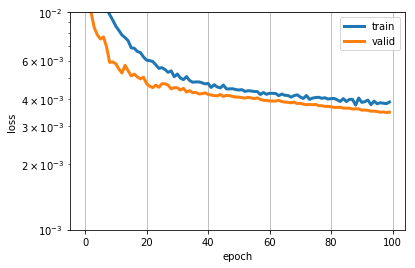

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)

# Because of the large range of losses, we use 'log' to convert
plt.yscale('log') 
plt.show()

**
The result is not very good, because the `steps_per_epoch` I didn't use very large number.**

**I don't have too much time to train, and the graphics card in my PC is not GTX1080.**

**To solve this problem, we can use `steps_per_epoch = len(X_train)` to get better result.
**

In [44]:
X_test2, _ = load2d(test=True) 
y_pred2 = model2.predict(X_test2) 

ImageId    1783
Image      1783
dtype: int64


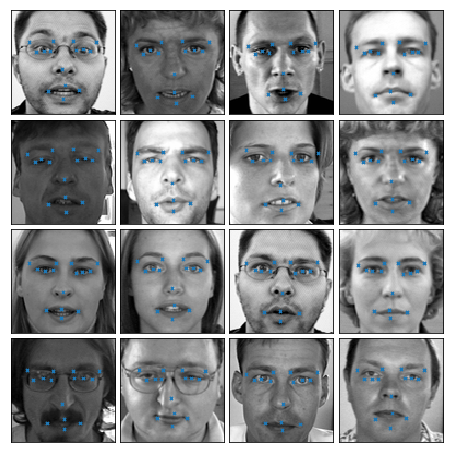

In [45]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)

plt.show()

## Visualize the predictions of both models

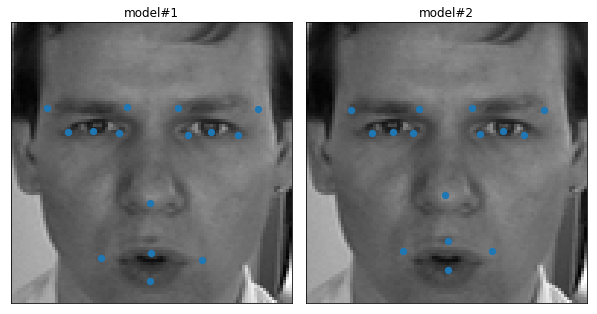

In [47]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96) 
    axis.imshow(img, cmap='gray') 
    
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='o', s=40)
    
    
fig = plt.figure(figsize=(8, 8))

# We find an image to compare the results of the two model predictions
idx = 50 

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# first model
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('model#1')
plot_sample(X_test[idx], y_pred[idx], ax)

# seconf model
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('model#2')
plot_sample(X_test2[idx], y_pred2[idx], ax)
 
plt.show()

In [50]:
columns=["left_eye_center_x","left_eye_center_y","right_eye_center_x","right_eye_center_y",
         "left_eye_inner_corner_x","left_eye_inner_corner_y","left_eye_outer_corner_x",
         "left_eye_outer_corner_y","right_eye_inner_corner_x","right_eye_inner_corner_y",
         "right_eye_outer_corner_x","right_eye_outer_corner_y","left_eyebrow_inner_end_x",
         "left_eyebrow_inner_end_y","left_eyebrow_outer_end_x","left_eyebrow_outer_end_y",
         "right_eyebrow_inner_end_x","right_eyebrow_inner_end_y","right_eyebrow_outer_end_x",
         "right_eyebrow_outer_end_y","nose_tip_x","nose_tip_y","mouth_left_corner_x",
         "mouth_left_corner_y","mouth_right_corner_x","mouth_right_corner_y","mouth_center_top_lip_x",
         "mouth_center_top_lip_y","mouth_center_bottom_lip_x","mouth_center_bottom_lip_y"]

y_pred_final = y_pred2 * 48 + 48

# # Because the image is 96x96, the coordinate point can only fall between [0 ~ 96]
y_pred_final = y_pred_final.clip(0,96) 
df = DataFrame(y_pred_final, columns=columns)
lookup_table = pd.read_csv(FLOOKUP)
values = []

for index, row in lookup_table.iterrows():
    values.append((row['RowId'], df.iloc[row.ImageId - 1][row.FeatureName]))
    
now_str = datetime.now().isoformat().replace(':','-')
submission = DataFrame(values, columns=('RowId', 'Location'))
path = "D:/Program/dataset/Facial Keypoints Detection"
filename = (path+'/submission-{}.csv').format(now_str)
submission.to_csv(filename, index=False)
print("Wrote {}".format(filename))

Wrote D:/Program/dataset/Facial Keypoints Detection/submission-2018-02-02T13-51-05.841470.csv


## Conclusion

* In the last output layer of the network does not set the activation function approach with the general mechanical learning **regression** is very similar.

* This article preprocessing filter about 5000 missing data, and only 2,267 pen training data is used to simplify the description of the article, in practice, the number of training materials are not many The dataset should reinforce the missing values feature program

## Reference:

[Using convolutional neural nets to detect facial keypoints tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)